In [1]:
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.9.2


In [3]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x) #normalization
x= Dropout(0.5)(x)

preds=Dense(6,activation='softmax')(x) #FC-layer

29084464/29084464 [==============================] - 3s 0us/step


In [4]:
model=Model(inputs=model_d.input,outputs=preds)
#model.summary()

for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [5]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
#model.summary()

In [6]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("/kaggle/input/garbage-classification/Garbage classification/Garbage classification/")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("/kaggle/input/garbage-classification/Garbage classification/Garbage classification/"+img)))
    for i in path:
        image = cv2.imread("/kaggle/input/garbage-classification/Garbage classification/Garbage classification/"+img+'/'+i)
        image = cv2.resize(image, (128,128))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['paper', 'glass', 'metal', 'plastic', 'cardboard', 'trash']


In [7]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 1 0 0]


In [8]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.4,random_state=42)
print(xtrain.shape, xtest.shape)

(1516, 128, 128, 3) (1011, 128, 128, 3)


In [9]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.15, patience=6, verbose=True, min_lr=1e-8)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=64),
               steps_per_epoch=xtrain.shape[0] //64,
               epochs=100,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/100

Epoch 1: val_loss improved from inf to 13.81108, saving model to model.h5
23/23 - 30s - loss: 1.7779 - accuracy: 0.4793 - val_loss: 13.8111 - val_accuracy: 0.1761 - lr: 0.0010 - 30s/epoch - 1s/step
Epoch 2/100

Epoch 2: val_loss did not improve from 13.81108
23/23 - 7s - loss: 1.2744 - accuracy: 0.5916 - val_loss: 31.4143 - val_accuracy: 0.2263 - lr: 0.0010 - 7s/epoch - 320ms/step
Epoch 3/100

Epoch 3: val_loss improved from 13.81108 to 12.67895, saving model to model.h5
23/23 - 9s - loss: 0.9000 - accuracy: 0.6811 - val_loss: 12.6789 - val_accuracy: 0.2309 - lr: 0.0010 - 9s/epoch - 396ms/step
Epoch 4/100

Epoch 4: val_loss improved from 12.67895 to 1.82771, saving model to model.h5
23/23 - 9s - loss: 0.7092 - accuracy: 0.7638 - val_loss: 1.8277 - val_accuracy: 0.4281 - lr: 0.0010 - 9s/epoch - 378ms/step
Epoch 5/100

Epoch 5: val_loss improved from 1.82771 to 1.39123, saving model to model.h5
23/23 - 9s - loss: 0.6411 - accuracy: 0.7831 - val_loss: 1.3912 - val_accuracy: 0

In [11]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

32/32 [==============================] - 3s 34ms/step
Total-test-data; 1011 	accurately-predicted-data: 903 	 wrongly-predicted-data:  108
Accuracy: 89.318 %


In [12]:
pip install plot_keras_history

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 575.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9474 sha256=678e4b89502ab65428d1745e3f939c7a4ddf98aebc39e230c32170c109f7cc38
  Stored in directory: /root/.cache/pip/wheels/f1/91/1c/bdba9dfd430fdabe38c1077da71de189658be21716be91d184
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320514 sha256=8cae17414bab1ba774fce272e6f47cd93be000148e9baae3dded2b547f2139af
  Stored in directory: /root/.cache/pip/wheels/df/61/fa/0598614d92032edbee232e8a1ee86bba214cc4392a10f11e7e
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-n

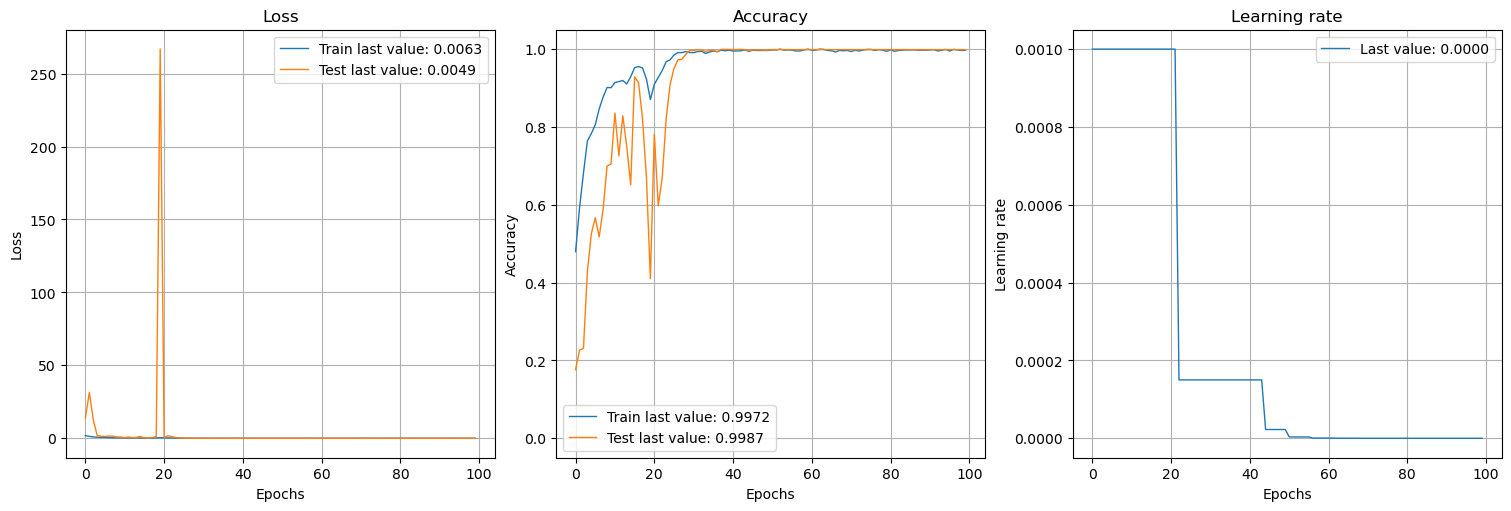

In [13]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

#model = my_keras_model()
#history = model.fit(...)
show_history(history)
plot_history(history)
plt.close()

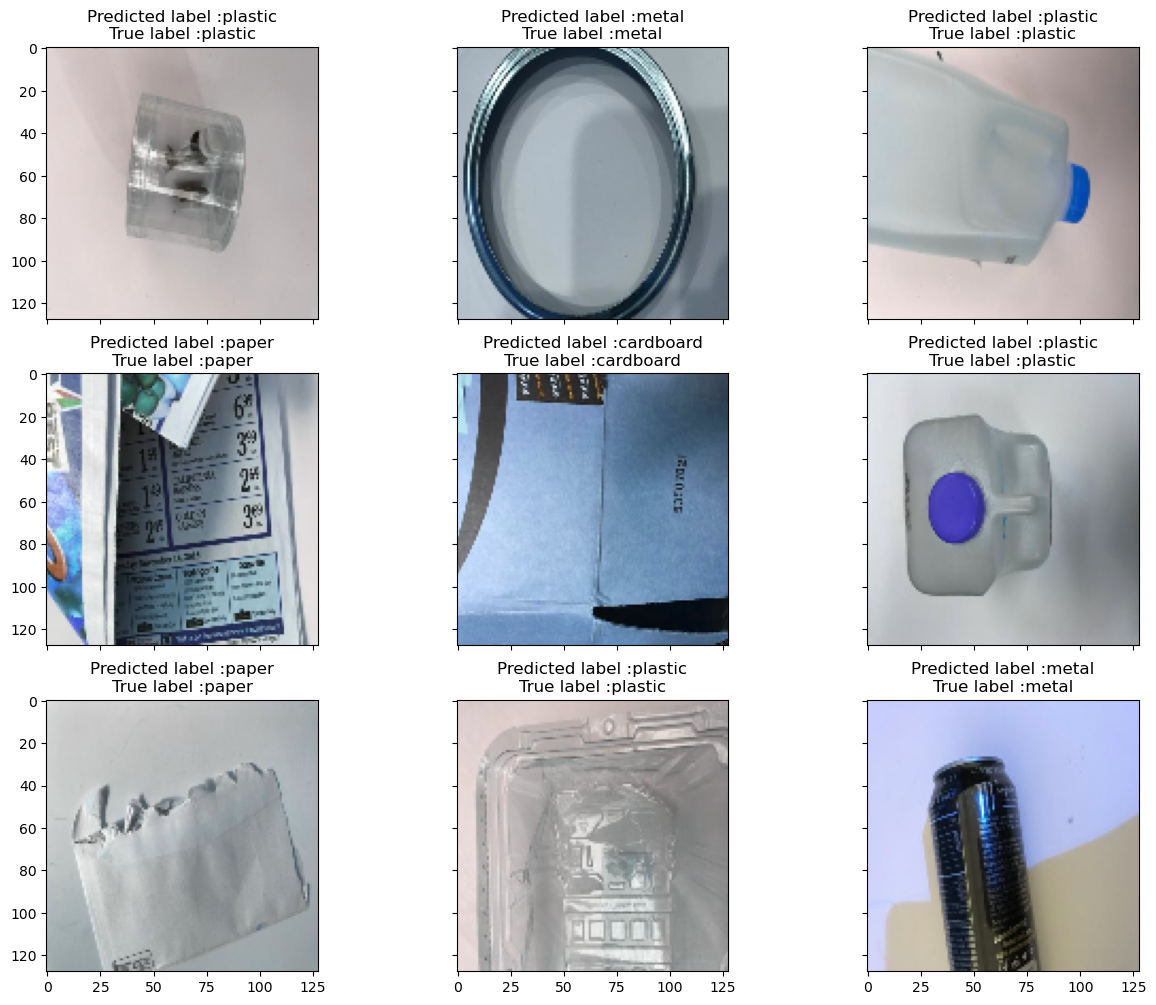

In [14]:
label=['cardboard', 'glass','metal', 'paper', 'plastic', 'trash']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

32/32 [==============================] - 1s 25ms/step


Text(0.5, 192.72222222222217, 'Predicted')

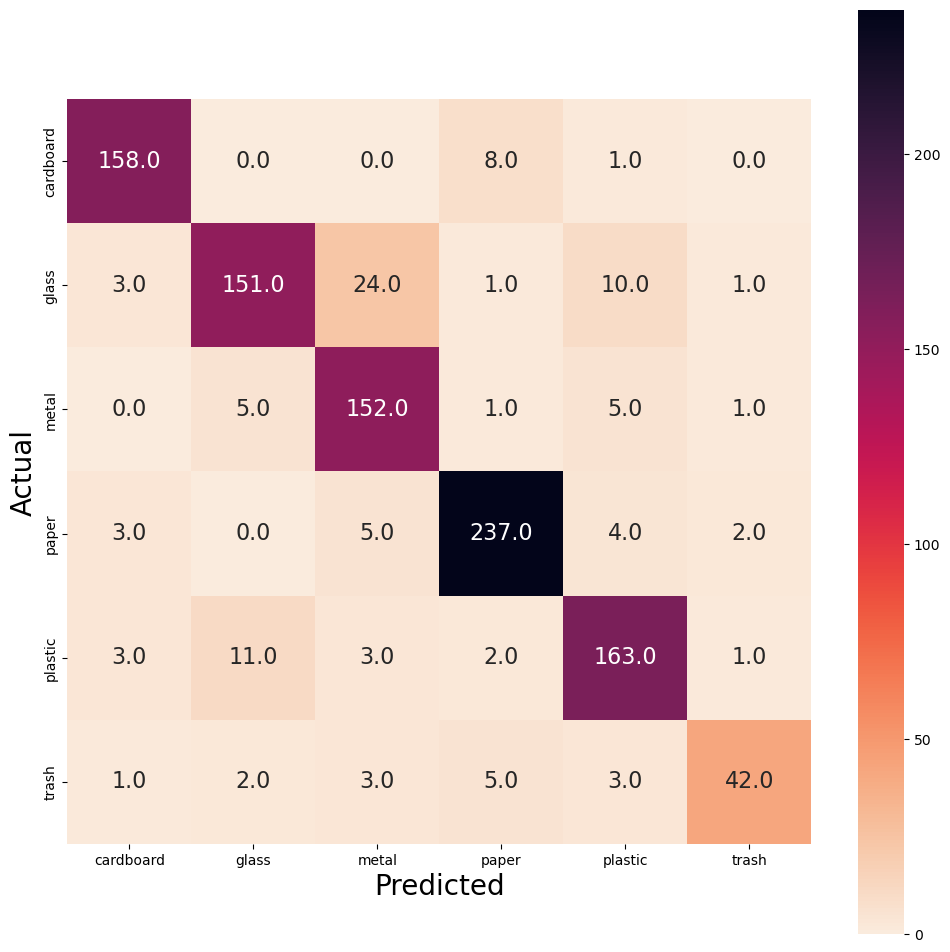

In [15]:
Ypred = model.predict(xtest)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(ytest, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)